# Hepatic clearance model
Simple example model for coupling to sinusoidal and PKPD model structure.
Detoxification of substance `S` via hepatic transformation to `P`.

['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


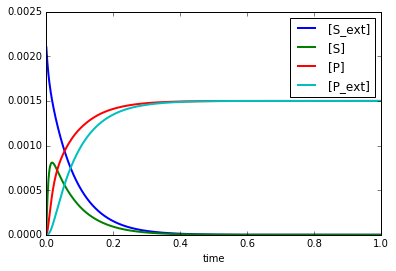

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

In [5]:
# simulation to steady state
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance
r = te.loads(clearance.sbml_path)
r.integrator.absolute_tolerance = 1E-20

# print(r.getAntimony(current=False))
r.resetToOrigin()
s = r.simulate(0,1,steps=1001)
print(r.selections)
r.plot(s)

## Time dependent challenge

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

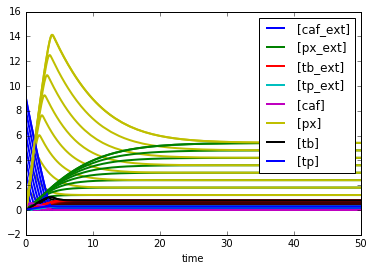

In [11]:
# give a time dependent challenge via composition of models
r.integrator.variable_step_size = True
for k in range(10):
    r.reset()
    r['[caf_ext]'] = k
    s = r.simulate(0, 50)
    r.plot(s, show=False, loc=False)
r.plot(s, show=False)

Internal and external concentrations reach equilibrium.

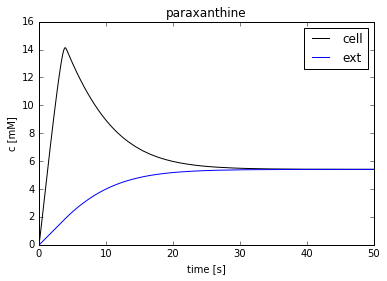

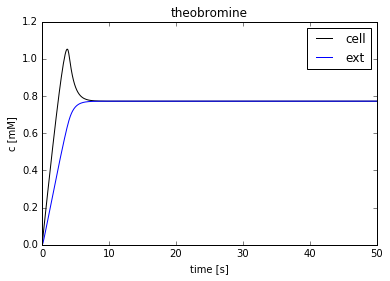

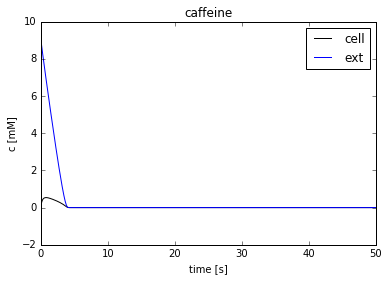

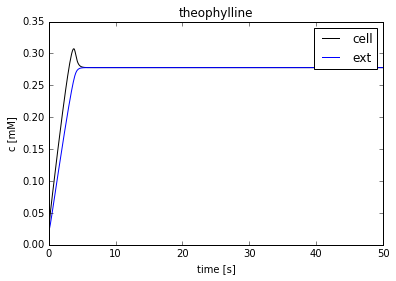

In [15]:
for key, name in {'caf': 'caffeine', 
                  'px': 'paraxanthine', 
                  'tb': 'theobromine', 
                  'tp': 'theophylline'}.iteritems():
    plt.plot(s['time'], s['[{}]'.format(key)], color='black', label='cell')
    plt.plot(s['time'], s['[{}_ext]'.format(key)], color='blue', label='ext')
    plt.title(name)
    plt.xlabel('time [s]')
    plt.ylabel('c [mM]')
    
    plt.legend()
    plt.show()
